# Computer Vision Lecture - Exercise 1 - Image Formation

In this exercise, you will gain hands-on experience regarding the image formation process and geometric transformations. More specifically, we will develop our own simple renderer and play around with focal lengths, BRDF-based shading, rotations, translations, and much more! In the second part of the notebook, we will have a look at homographies and how they can be used to stitch together images to form panoramas.

This notebook guides you through the relevant steps. When you see helper functions, you don't need to do anything - they are already implemented. The functions you need to implement are indicated as Exercise Function. Sometimes, you can find Hints - these are written upside-down so you can first try to find the solution without reading them.

Good luck and lot's of fun!

## Preliminaries

Let's first import relevant libaries and define hyperparameters. For the latter, we set the image height H and width W to 128 pixels.

In [1]:
import numpy as np
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from IPython.display import HTML
from matplotlib import animation
from matplotlib.patches import Polygon
import cv2

# Let's first define hyperparameters. In our case, we set the image height H and width H to 128 pixels.
H, W = 128, 128

We need an object in our scene in order to render more than an empty image! For this, we define a helper function which returns the faces (and optionally the face normals) of a cube. 

In [2]:
###########################
##### Helper Function #####
###########################
def get_cube(center=(0, 0, 2), rotation_angles=[0., 0., 0.], with_normals=False, scale=1.):
    ''' Returns an array containing the faces of a cube.

    Args:
    center (tuple): center of the cube
    rotation_angles (tuple): Euler angles describing the rotation of the cube
    with_normals (bool): whether to return the normal vectors of the faces
    scale (float): scale of cube

    '''
    # A cube consists of 6 faces and 8 corners:
    #   +----+
    #  /    /|
    # +----+ |
    # |    | +
    # |    |/
    # +----+
    # Let's first consider the unit cube. The corners are:
    corners = np.array([(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)])
    # Let's now center the cube at (0, 0, 0)
    corners = corners - np.array([0.5, 0.5, 0.5], dtype=np.float32).reshape(1, 3)
    # Let's scale the cube
    corners = corners * scale
    # And we rotate the cube wrt. the input rotation angles
    rot_mat = R.from_euler('xyz', rotation_angles, degrees=True).as_matrix()
    corners = np.matmul(corners, rot_mat.T)
    # Finally, we shift the cube according to the input center tuple
    corners = corners + np.array(center, dtype=np.float32).reshape(1, 3)

    # The 6 faces of the cube are then given as:
    faces = np.array([
    # all faces containing (0, 0, 0)
    [corners[0], corners[1], corners[3], corners[2]],
    [corners[0], corners[1], corners[5], corners[4]],
    [corners[0], corners[2], corners[6], corners[4]],
    # all faces containing (1, 1, 1)
    [corners[-1], corners[-2], corners[-4], corners[-3]],
    [corners[-1], corners[-2], corners[-6], corners[-5]],
    [corners[-1], corners[-3], corners[-7], corners[-5]],
    ])

    if with_normals:
        normals = np.array([(-1, 0, 0), (0, -1, 0), (0, 0, -1), (1, 0, 0), (0, 1, 0), (0, 0, 1)])
        normals = np.matmul(normals, rot_mat.T)
        return faces, normals
    else:
        return faces

## Perspective Projection

In the first part of the exercise, we will use the pinhole camera model which performs a perspective projection. After developing the projection and shading functions, we will play around with geometric transformations and analyze the effect of the focal lengths!

### Exercise Function 1
We arrive at our first exercise function. Your task is complete the function get_camera_intrinsics which returns a 3x3 camera matrix for provided focal lengths fx, fy and the principal point (cx, cy).

In [3]:
###########################
#### Exercise Function ####
###########################
def get_camera_intrinsics(fx=70, fy=70, cx=W/2., cy=H/2.):
    ''' Returns the camera intrinsics matrix.

    Hint: The array should be of size 3x3 and of dtype float32 (see the assertion below)

    Args:
    fx (float): focal length in x-direction f_x
    fy (float): focal length in y-direction f_y
    cx (float): x component of the principal point
    cy (float): y compontent of th principal point
    '''
    
    # Insert your code here
    K = np.array([(fx, 0, cx), (0, fy, cy), (0, 0, 1)], dtype=np.float32).reshape(3, 3)

    assert(K.shape == (3, 3) and K.dtype == np.float32)
    return K

### Exercise Function 2

We now develop the function `get_perspective_projection`. It takes in a 3D point in camera space `x_c` and the camera matrix `K` and it returns the point in screen space (i.e. the pixel coordinates) `x_s`. Note that we return a 2D vector for `x_s` as we drop the final value (which is always 1).

In [12]:
def get_perspective_projection(x_c, K):
    ''' Projects the 3D point x_c to screen space and returns the 2D pixel coordinates.
    
    Args:
        x_c (array): 3D point in camera space
        K (array): camera intrinsics matrix (3x3)
    '''
    assert(x_c.shape == (3,) and K.shape == (3, 3))

    # Insert your code here
    x_s = np.matmul(K, x_c)
    x_s = x_s[:2]/x_s[2]
    return x_s

Here, we provide a helper function to project the entire cube using the camera matrix K.

In [13]:
###########################
##### Helper Function #####
###########################
def project_cube(cube, K):
    ''' Projects the cube.
    
    Args:
        cube (array): cube
        K (array): camera intrinsics matrix
    '''
    s = cube.shape
    assert(s[-1] == 3)
    cube = cube.reshape(-1, 3)
    projected_cube = np.stack([get_perspective_projection(p, K) for p in cube])
    projected_cube = projected_cube.reshape(*s[:-1], 2)
    return projected_cube

To see if our developed functions make sense, let's have a look at a projection! But first, we need to write a function which plots the projected cube - this is provided here.

In [14]:
###########################
##### Helper Function #####
###########################
def plot_projected_cube(projected_cube, figsize=(5, 5), figtitle=None, colors=None, face_mask=None):
    ''' Plots the projected cube.

    Args:
    projected_cube (array): projected cube (size 6x4x2)
    figsize (tuple): size of the figure
    colors (list): list of colors for polygons. If None, 'blue' is used for all faces
    face_mask (array): mask for individual faces of the cube. If None, all faces are drawn.
    '''
    assert(projected_cube.shape == (6, 4, 2))
    fig, ax = plt.subplots(figsize=figsize)
    if figtitle is not None:
        fig.suptitle(figtitle)
    if colors is None:
        colors = ['C0' for i in range(len(projected_cube))]
    if face_mask is None:
        face_mask = [True for i in range(len(projected_cube))]
    ax.set_xlim(0, W), ax.set_ylim(0, H)
    ax.set_xlabel('Width'), ax.set_ylabel("Height")
    for (cube_face, c, mask) in zip(projected_cube, colors, face_mask):
        if mask:
            ax.add_patch(Polygon(cube_face, color=c))
    plt.show()

Let's have a look at our first rendering of a cube! We get our camera matrix `K` and the cube `cube`, then we project it using the `project_cube` function, and finally we can visualize the projection using the `plot_projected_cube function`.

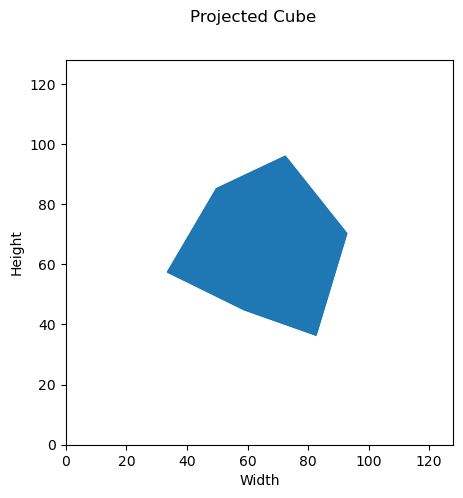

In [15]:
K = get_camera_intrinsics()
cube = get_cube(rotation_angles=[30, 50, 0])
projected_cube = project_cube(cube, K)
plot_projected_cube(projected_cube, figtitle='Projected Cube')

Doesn't look to bad! However, all faces have the same color, so we cannot really see which face of the cube is in front. For this, let's develop a simple shading function next!

### Exercise Function 3

We now develop the function `get_face_color`. For the input `normal` of a cube face and the `point_light direction` vector for a point light source, we calculate the color intensity using the rendering equation. We then stack the color intensity three times to obtain a RGB color value (scaled between 0.1 and 0.9 to avoid pure white/black). For calculating the light intensity, have a closer look at the rendering equation discussed in the lecture. You can assume that the surface does not emit light and that the BRDF term is always 1. The incoming light is exactly 1 for the direction of the point light source.

In [ ]:
###########################
#### Exercise Function ####
###########################
def get_face_color(normal, point_light_direction=(0, 0, 1)):
    ''' Returns the face color for input normal.
    
    Args:
        normal (array): 3D normal vector
        point_light_direction (tuple): 3D point light direction vector
    '''
    assert(normal.shape == (3,))
    point_light_direction = np.array(point_light_direction, dtype=np.float32)

    # Insert your code here
    
    color_intensity = 0.1 + (light_intensity * 0.5 + 0.5) * 0.8
    color = np.stack([color_intensity for i in range(3)])
    return color

We provide a helper function which returns the face colors for multiple normals by looping over them and returning stacking the output of the `get_face_color` function.

In [ ]:
###########################
##### Helper Function #####
###########################
def get_face_colors(normals, light_direction=(0, 0, 1)):
    ''' Returns the face colors for given normals and viewing direction.

    Args:
    normals (array): face normals (last dimension is 3)
    light_direction (tuple): light direction vector
    '''
    colors = np.stack([get_face_color(normal, light_direction) for normal in normals])
    return colors

When using different colors for the cube faces, we now also need to reason about which face is visible in the image. This function is provided in the following. We use a very simple heuristic here based on the face normals and the viewing direction which works for our examples.

In [ ]:
###########################
##### Helper Function #####
###########################
def get_face_mask(cube, normals, camera_location=(0, 0, 0)):
    ''' Returns a mask for each face of the cube whether it is visible when projected.
    
    Args:
    cube (array): cube faces
    normals (array): face normals (last dimension is 3)
    camera_location (tuple): viewing camera location vector
    '''
    assert(cube.shape == (6, 4, 3) and normals.shape[-1] == 3)
    camera_location = np.array(camera_location).reshape(1, 3) 

    face_center = np.mean(cube, axis=1)
    viewing_direction = camera_location - face_center
    dot_product = np.sum(normals * viewing_direction, axis=-1)
    mask = dot_product > 0.0
    return mask

Great, let's have a look at our projected cube with shading!

In [ ]:
cube, normals = get_cube(rotation_angles=[30, 50, 0], with_normals=True)
colors = get_face_colors(normals)
mask = get_face_mask(cube, normals)
projected_cube = project_cube(cube, get_camera_intrinsics())
plot_projected_cube(projected_cube, figtitle="Projected Cuboid with Shading", colors=colors, face_mask=mask)

Looks much better, right? We can see that **shading is a strong cue for reasoning about 3D geometry**. In the following, we will create animations where we rotate the cube or change the focal lengths.

The next function `get_animation` returns a matplotlib animation for given lists of camera matrices and cubes.

In [ ]:
###########################
##### Helper Function #####
###########################
def get_animation(K_list, cube_list, figsize=(5, 5), title=None):
    ''' Create a matplotlib animation for the list of camera matrices and cubes with face normals.

    Args:
    K_list (list): list of camera matrices
    cube_list (list): list of cubes
    figsize (tuple): matplotlib figsize
    title (str): if not None, the title of the figure
    '''
    assert(len(K_list) == len(cube_list))

    # split cube_list into cubes and normals
    cubes = [i[0] for i in cube_list]
    normals = [i[1] for i in cube_list]

    # get face colors and masks
    colors = [get_face_colors(normals_i) for normals_i in normals]
    masks = [get_face_mask(cube_i, normals_i) for (cube_i, normals_i) in zip(cubes, normals)]

    # get projected cubes
    projected_cubes = [project_cube(cube, Ki) for (cube, Ki) in zip(cubes, K_list)]

    # initialize plot
    uv = projected_cubes[0]
    patches = [Polygon(uv_i, closed=True, color='white') for uv_i in uv]

    # Define animation function
    def animate(n):
        ''' Animation function for matplotlib visualizations.
        '''
        uv = projected_cubes[n]
        color = colors[n]
        mask = masks[n]
        for patch, uv_i, color_i, mask_i in zip(patches, uv, color, mask):
            if mask_i:
                patch.set_xy(uv_i)
                patch.set_color(color_i)
            else:
                uv_i[:] = -80
                patch.set_color(color_i)
                patch.set_xy(uv_i)
        return patches

    fig, ax = plt.subplots(figsize=figsize)
    if title is not None:
        fig.suptitle(title)
    plt.close()
    ax.set_xlim(0, W)
    ax.set_ylim(0, H)
    for patch in patches:
        ax.add_patch(patch)
    anim = animation.FuncAnimation(fig, animate, frames=len(K_list), interval=100, blit=True)
    return anim

With this helper function, we can now create cool animations! Let's start off with creating a list of camera matrices and a list of cubes with normals where we rotate the cube along the y-axis.

In [ ]:
K_list = [get_camera_intrinsics() for i in range(30)]
cube_list = [get_cube(rotation_angles=[0, angle, 0], with_normals=True) for angle in np.linspace(0, 360, 30)]
anim = get_animation(K_list, cube_list, title="Rotation of Cube")
HTML(anim.to_html5_video())

Next, we can analyze the effect of changing the focal lenghs. Let's start with the focal length in x-direction.

In [ ]:
K_list = [get_camera_intrinsics(fx=f) for f in np.linspace(10, 150, 30)]
cube_list = [get_cube(rotation_angles=(0, 30, 50), with_normals=True) for i in range(30)]
anim = get_animation(K_list, cube_list, title="Change of focal length along the x-axis.")
HTML(anim.to_html5_video())

### Exercise Function 4 and 5

Create a visualization where you change both focal lengths similarly to the previous example. Further, create a visualization where you translate the cube along the y-axis between the values [-2, 2].

*Hint 1*: ˙uoᴉʇɔunɟ ǝqnɔ‾ʇǝƃ ǝɥʇ ɟo ʇuǝɯnƃɹɐ ɹǝʇuǝɔ ǝɥʇ ǝʇɐlndᴉuɐɯ 'ǝqnɔ ǝɥʇ ƃuᴉʇɐlsuɐɹʇ ɹoℲ

In [ ]:
###########################
#### Exercise Function ####
###########################
# Insert your code here

In [ ]:
###########################
#### Exercise Function ####
###########################
# Insert your code here

### Exercise Function 6 - Dolly Zoom Effect

Great! As you are now familiar with manipulating the focal lengths as well as translating the object, we can now even create the Dolly Zoom effect! For this, linearly change the focal lengths between 10 and 150 while also translating the cube along the z-axis between 0.9 and 5.

In [ ]:
###########################
#### Exercise Function ####
###########################
# Insert your code here

Great! If you implemented it correctly, the size of the cube should not change while the perspective distortion changes (this effect has also been used in movies, check out https://en.wikipedia.org/wiki/Dolly_zoom for more information).

## Comparison of Perspective and Orthographic Projection

We have now seen the effect of a perspective transformation. Let's contrast this against an orthographic projection in the following!

### Exercise Function 7

Complete the function `get_orthographic_projection` which maps an input point in camera space `x_c` to 2D pixel coordinates `x_s`.

In [ ]:
###########################
#### Exercise Function ####
###########################
def get_orthographic_projection(x_c):
    ''' Projects the 3D point in camera space x_c to 2D pixel coordinates using an orthographic projection.
    
    Args:
        x_c (array): 3D point in camera space
    '''
    assert(x_c.shape == (3,))

    # Insert your code here

    assert(x_s.shape == (2,))
    return x_s

Here, we provide a helper function to project the entire cube using the `get_orthographic_projection` function.

In [ ]:
def project_cube_orthographic(cube):
    ''' Projects the cube using an orthographic projection.
    
    Args:
        cube (array): cube
    '''
    s = cube.shape
    assert(s[-1] == 3)
    cube = cube.reshape(-1, 3)
    projected_cube = np.stack([get_orthographic_projection(p) for p in cube])
    projected_cube = projected_cube.reshape(*s[:-1], 2)
    return projected_cube

Now, let's have a look how the cube from earlier looks like when we project it via the orthographic projection. (To obtain a similar-sized cube, we need to increase its scale to account for the missing scale factor; instead, we could also use a scaled orthographic projection, but we choose this approach for simplicity.)

In [ ]:
cube, normals = get_cube(center=(60., 60., 100), rotation_angles=[30, 50, 0], scale=60., with_normals=True)
colors = get_face_colors(normals)
mask = get_face_mask(cube, normals)
projected_cube = project_cube_orthographic(cube)
plot_projected_cube(projected_cube, figtitle="Orthographic-Projected Cube with Shading", colors=colors, face_mask=mask)

### Exercise Function 8

How would you describe your result? Compare it against the visualization of the dolly zoom. When does the perspective projection look most similar to the orthographic projection?

To confirm your analysis, plot a cube with center `(0, 0, 150)` and the same rotation angles `(30, 50, 0)` which you project with a camera matrix with focal lengths of `10000`.

In [ ]:
###########################
#### Exercise Function ####
###########################
# Insert your code here

## Panorama Stitching

In the second part of the exercise, we have a look at homographies and how they can be used to stitch together photos!

Let's first import the two images we want to stich together and the pre-computed point pairs.

In [ ]:
# Load images
img1 = cv2.cvtColor(cv2.imread('./image-1.jpg'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('./image-2.jpg'), cv2.COLOR_BGR2RGB)

# Load matching points
npz_file = np.load('./panorama_points.npz')
points_source = npz_file['points_source']
points_target = npz_file['points_target']

Let's have a look at the two images

In [ ]:
# Let's visualize the images
f = plt.figure(figsize=(15, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.imshow(img1)
ax2.imshow(img2)

Let's also have a look at some correspondence pairs! For this, the `draw_matches` function is provided.

In [ ]:
###########################
##### Helper Function #####
###########################
def draw_matches(img1, points_source, img2, points_target):
    ''' Returns an image with matches drawn onto the images.
    '''
    r, c = img1.shape[:2]
    r1, c1 = img2.shape[:2]

    output_img = np.zeros((max([r, r1]), c + c1, 3), dtype='uint8')
    output_img[:r, :c, :] = np.dstack([img1])
    output_img[:r1, c:c + c1, :] = np.dstack([img2])

    for p1, p2 in zip(points_source, points_target):
        (x1, y1) = p1[:2]
        (x2, y2) = p2[:2]

        cv2.circle(output_img, (int(x1), int(y1)), 10, (0, 255, 255), 10)
        cv2.circle(output_img, (int(x2) + c, int(y2)), 10, (0, 255, 255), 10)

        cv2.line(output_img, (int(x1), int(y1)), (int(x2) + c, int(y2)), (0, 255, 255), 5)

    return output_img

In [ ]:
f = plt.figure(figsize=(20, 10))
vis = draw_matches(img1, points_source[:5], img2, points_target[:5])
plt.imshow(vis)

### Exercise Function 9

After looking at the correspondences, let's stitch the images together! In order to stich together the images, we need a function to return the 2x9 "A_i" matrix discussed in the lecture for a given 2D correspondence pair `xi_vector` and `xi_prime_vector` (these are 3D homogeneous vectors).

In [ ]:
###########################
#### Exercise Function ####
###########################
def get_Ai(xi_vector, xi_prime_vector):
    ''' Returns the A_i matrix discussed in the lecture for input vectors.
    
    Args:
        xi_vector (array): the x_i vector in homogeneous coordinates
        xi_vector_prime (array): the x_i_prime vector in homogeneous coordinates
    '''
    assert(xi_vector.shape == (3,) and xi_prime_vector.shape == (3,))

    # Insert your code here
    
    assert(Ai.shape == (2, 9))
    return Ai

### Exercise Function 10

Using `get_Ai`, write a function `get_A` which returns the A matrix of size 2Nx9.

In [ ]:
###########################
#### Exercise Function ####
###########################
def get_A(points_source, points_target):
    ''' Returns the A matrix discussed in the lecture.
    
    Args:
        points_source (array): 3D homogeneous points from source image
        points_target (array): 3D homogeneous points from target image
    '''
    N = points_source.shape[0]

    # Insert your code here
    
    assert(A.shape == (2*N, 9))
    return A

### Exercise Function 11

Next, implement the function `get_homography` which returns the homography H for point corrspondence pairs. You should obtain H by performing the Direct Linear Transformation (DLT) algorithm (consisting of 3 steps).

*Hint 1*: ˙uoᴉʇɔunɟ ∀ʇǝƃ ǝɥʇ ƃuᴉsn xᴉɹʇɐɯ ∀ ǝɥʇ uᴉɐʇqo ʇsɹᴉɟ

*Hint 2*: ˙(pʌs˙ƃlɐuᴉl˙du ƃuᴉsn ƃǝ) ∀ uo pΛS ɯɹoɟɹǝd 'ʇxǝu

*Hint 3*: ˙xᴉɹʇɐɯ Λ pǝsodsuɐɹʇ ǝɥʇ ɟo ǝnlɐʌ ʇsɐl ǝɥʇ ʇɔǝlǝs 'ʎllɐuᴉɟ

In [ ]:
###########################
#### Exercise Function ####
###########################
def get_homography(points_source, points_target):
    ''' Returns the homography H.
    
    Args:
        points_source (array): 3D homogeneous points from source image
        points_target (array): 3D homogeneous points from target image        
    '''

    # Insert your code here

    assert(H.shape == (3, 3))
    return H

We need a function which takes in the two images and the calculated homography and it returns the stiched image in a format which we can display easy with matplotlib. This function is provided in the following.

In [ ]:
###########################
##### Helper Function #####
###########################
def stich_images(img1, img2, H):
    ''' Stitches together the images via given homography H.

    Args:
        img1 (array): image 1
        img2 (array): image 2
        H (array): homography
    '''

    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]

    list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
    temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

    list_of_points_2 = cv2.perspectiveTransform(temp_points, H)
    list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

    translation_dist = [-x_min,-y_min]

    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

    output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
    output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

    return output_img

Finally, we can have a look at our panorama! 

In [ ]:
H = get_homography(points_target, points_source)
stiched_image = stich_images(img1, img2, H)
fig = plt.figure(figsize=(15, 10))
fig.suptitle("Stiched Panorama")
plt.imshow(stiched_image)

### Exercise Function 12

Now, it's your turn: Create your own panorama! Go out and take two photos with your smartphone or camera and save them to your computer. Make sure that you only change the angle of the phone/camera, not the position! Save them to the lecture exercise folder and cange the file paths for `img1` and `img2` below to your own images!

In [ ]:
###########################
#### Exercise Function ####
###########################
# Load images
img1 = cv2.cvtColor(cv2.imread('./path/to/your/image-1'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('./path/to/your/image-2'), cv2.COLOR_BGR2RGB)
# Let's visualize the images
f = plt.figure(figsize=(15, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.imshow(img1)
ax2.imshow(img2)

For obtaining the homography, we need correspondence pairs. In the following we provide a function for this based on feature matching.

In [ ]:
###########################
##### Helper Function #####
###########################
def get_keypoints(img1, img2):
    orb = cv2.ORB_create(nfeatures=2000)

    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)
    bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)

    # Find matching points
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.5 * n.distance:
            good.append(m)
    p_source = np.float32([ keypoints1[good_match.queryIdx].pt for good_match in good ]).reshape(-1,2)
    p_target = np.float32([ keypoints2[good_match.trainIdx].pt for good_match in good ]).reshape(-1,2)
    N = p_source.shape[0]
    p_source = np.concatenate([p_source, np.ones((N, 1))], axis=-1)
    p_target = np.concatenate([p_target, np.ones((N, 1))], axis=-1)
    return p_source, p_target

Let's have a look at your own panorama!

In [ ]:
p_source, p_target = get_keypoints(img1, img2)
H = get_homography(p_target, p_source)
stiched_image = stich_images(img1, img2, H)
fig = plt.figure(figsize=(15, 10))
fig.suptitle("Stiched Panorama")
plt.imshow(stiched_image)

Great job! You now gained hands-on experience in the fields of image formation and panorama stitching!